# **Malaria Detection**

###<b> Mounting the Drive

In [7]:
#Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###<b>Loading libraries</b>

In [5]:
#Importing libraries required to load the data

import zipfile
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, LeakyReLU, GlobalAvgPool2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers

#to ignore warnings
import warnings
warnings.filterwarnings('ignore')


pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)

### <b>Loading the data</b>

In [8]:

path = '/content/drive/MyDrive/CNN Project Malaria Detection /cell_images.zip'

with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall()

In [9]:
#Storing the path of the extracted "train" folder 
train_dir = '/content/cell_images/train'

#Size of image so that each image has the same size
SIZE = 64

#Empty list to store the training images after they are converted to NumPy arrays
train_images = []

#Empty list to store the training labels (0 - uninfected, 1 - parasitized)
train_labels = []

In [10]:

for folder_name in ['/parasitized/', '/uninfected/']:
    
    #Path of the folder
    images_path = os.listdir(train_dir + folder_name)

    for i, image_name in enumerate(images_path):
        try:
            #Opening each image using the path of that image
            image = Image.open(train_dir + folder_name + image_name)

            #Resizing each image to (224,224)
            image = image.resize((SIZE, SIZE))

            #Converting images to arrays and appending that array to the empty list defined above
            train_images.append(np.array(image))

            #Creating labels for parasitized and uninfected images
            if folder_name=='/parasitized/':
                train_labels.append(1)
            else:
                train_labels.append(0)
        except Exception:
            pass       

#Converting lists to arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [11]:
#Storing the path of the extracted "test" folder 
test_dir = '/content/cell_images/test'

#Size of image so that each image has the same size (it must be same as the train image size)
SIZE = 64

#Empty list to store the testing images after they are converted to NumPy arrays
test_images = []

#Empty list to store the testing labels (0 - uninfected, 1 - parasitized)
test_labels = []

In [12]:

for folder_name in ['/parasitized/', '/uninfected/']:
    
    #Path of the folder
    images_path = os.listdir(test_dir + folder_name)

    for i, image_name in enumerate(images_path):
        try:
            #Opening each image using the path of that image
            image = Image.open(test_dir + folder_name + image_name)
            
            #Resizing each image to (128,128)
            image = image.resize((SIZE, SIZE))
            
            #Converting images to arrays and appending that array to the empty list defined above
            test_images.append(np.array(image))
            
            #Creating labels for parasitized and uninfected images
            if folder_name=='/parasitized/':
                test_labels.append(1)
            else:
                test_labels.append(0)
        except Exception:
            pass       

#Converting lists to arrays
test_images = np.array(test_images)
test_labels = np.array(test_labels)

###<b>Normalizing the images

In [13]:
# normalizing the train and test images by dividing them by 255 and converting them to float32
og_train_images = train_images
og_test_images = test_images

train_images = (train_images/255).astype('float32')
test_images = (test_images/255).astype('float32')

###<B>One Hot Encoding on the train and test labels

In [14]:
# Encoding Train Labels
train_labels=to_categorical(train_labels,2)
# Encoding the test labels
test_labels=to_categorical(test_labels,2)

### **Base Model**


####<b> Importing the required libraries

In [15]:
#Clearing backend
from tensorflow.keras import backend
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout  
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from random import shuffle

backend.clear_session()
#Fixing the seed for random number generators so to ensure the same output every time
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

####<b> Building the model

In [16]:

#creating sequential model
model=Sequential()
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu",input_shape=(64,64,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))


model.add(Flatten())

model.add(Dense(512,activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(2,activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 32)        0

####<b> Compiling the model

In [17]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

<b> Using Callbacks 

In [18]:
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]

<b> Fitting and training the Model

In [19]:

history=model.fit(train_images,train_labels,batch_size=32,callbacks=callbacks,validation_split=0.2,epochs=20,verbose=1)

Epoch 1/20
624/624 [==============================] - 18s 15ms/step - loss: 0.4541 - accuracy: 0.7756 - val_loss: 0.2636 - val_accuracy: 0.8962
Epoch 2/20
624/624 [==============================] - 8s 13ms/step - loss: 0.1730 - accuracy: 0.9390 - val_loss: 0.2408 - val_accuracy: 0.9505
Epoch 3/20
624/624 [==============================] - 8s 13ms/step - loss: 0.1582 - accuracy: 0.9465 - val_loss: 0.1455 - val_accuracy: 0.9792
Epoch 4/20
624/624 [==============================] - 8s 13ms/step - loss: 0.1490 - accuracy: 0.9495 - val_loss: 0.1714 - val_accuracy: 0.9663
Epoch 5/20
624/624 [==============================] - 8s 13ms/step - loss: 0.1407 - accuracy: 0.9532 - val_loss: 0.1690 - val_accuracy: 0.9609


####<b> Evaluating the model on test data

In [20]:
accuracy = model.evaluate(test_images, test_labels, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy[1])

82/82 [==============================] - 1s 7ms/step - loss: 0.1546 - accuracy: 0.9512

 Test_Accuracy:- 0.9511538743972778


<b> Plotting the confusion matrix

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1300
           1       0.96      0.94      0.95      1300

    accuracy                           0.95      2600
   macro avg       0.95      0.95      0.95      2600
weighted avg       0.95      0.95      0.95      2600



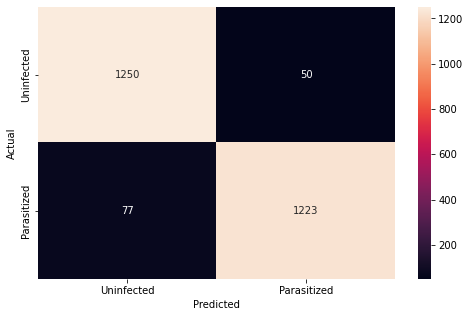

In [21]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred = model.predict(test_images)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(test_labels,axis = 1)

#Printing the classification report
print(classification_report(y_true,pred))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true,pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

<b>Plotting the train and validation curves

In [22]:
# function to plot train and validation accuracy 
def plot_accuracy(history):
    N = len(history.history["accuracy"])
    plt.figure(figsize=(7,7))
    plt.plot(np.arange(0, N), history.history["accuracy"], label="train_accuracy", ls='--')
    plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_accuracy", ls='--')
    plt.title("Accuracy vs Epoch")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc="upper left")

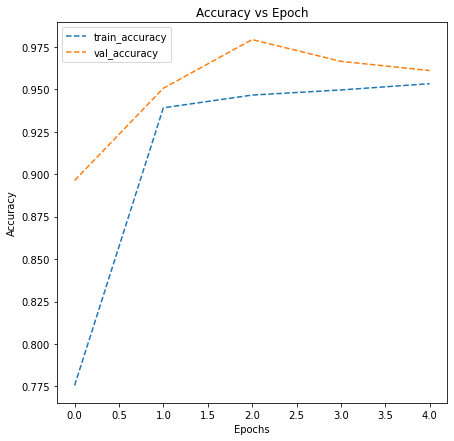

In [23]:
plot_accuracy(history)



* The training and valiation accuracy are increasing 
* The validation accuracy is slightly higher than the train accuracy

Now I will try to build another model with few more add on layers and try to check if I can try to improve the model. Therefore I try to build a model by adding few layers and altering the activation functions.

###<b> Model 1
####<b> Trying to improve the performance of our model by adding new layers


In [24]:
#Clearing backend
from tensorflow.keras import backend
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout  
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from random import shuffle

backend.clear_session()

np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

####<b> Building the Model

In [25]:
#creating sequential model
model1=Sequential()
model1.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu",input_shape=(64,64,3)))
model1.add(MaxPooling2D(pool_size=2))
model1.add(Dropout(0.2))
model1.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model1.add(MaxPooling2D(pool_size=2))
model1.add(Dropout(0.2))
model1.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model1.add(MaxPooling2D(pool_size=2))
model1.add(Dropout(0.2))
model1.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu")) #adding a 4th layer
model1.add(MaxPooling2D(pool_size=2))
model1.add(Dropout(0.2))


model1.add(Flatten())

model1.add(Dense(512,activation="relu"))
model1.add(Dropout(0.4))
model1.add(Dense(2,activation="softmax"))
model1.summary()





Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 32)        0

####<b> Compiling the model

In [26]:
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

<b> Using Callbacks

In [27]:
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]

<b>Fitting and Training the model

In [28]:
history1=model1.fit(train_images,train_labels,batch_size=32,callbacks=callbacks,  validation_split=0.2,epochs=20,verbose=1)

Epoch 1/20
624/624 [==============================] - 10s 15ms/step - loss: 0.4022 - accuracy: 0.8045 - val_loss: 0.1632 - val_accuracy: 0.9708
Epoch 2/20
624/624 [==============================] - 8s 14ms/step - loss: 0.1658 - accuracy: 0.9467 - val_loss: 0.1846 - val_accuracy: 0.9615
Epoch 3/20
624/624 [==============================] - 8s 13ms/step - loss: 0.1525 - accuracy: 0.9517 - val_loss: 0.1059 - val_accuracy: 0.9772
Epoch 4/20
624/624 [==============================] - 8s 13ms/step - loss: 0.1489 - accuracy: 0.9524 - val_loss: 0.1513 - val_accuracy: 0.9629
Epoch 5/20
624/624 [==============================] - 8s 13ms/step - loss: 0.1444 - accuracy: 0.9545 - val_loss: 0.1792 - val_accuracy: 0.9565


####<b> Evaluating the model

In [29]:
accuracy1 = model1.evaluate(test_images, test_labels, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy1[1])

82/82 [==============================] - 1s 7ms/step - loss: 0.1576 - accuracy: 0.9515

 Test_Accuracy:- 0.9515384435653687


<b> Plotting the confusion matrix

              precision    recall  f1-score   support

           0       0.95      0.96      0.95      1300
           1       0.96      0.95      0.95      1300

    accuracy                           0.95      2600
   macro avg       0.95      0.95      0.95      2600
weighted avg       0.95      0.95      0.95      2600



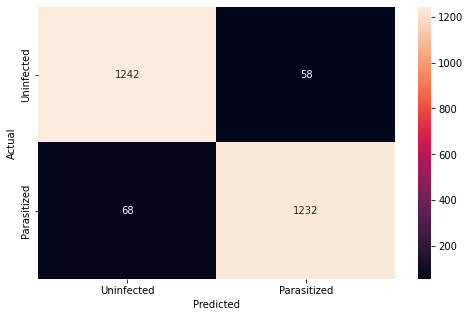

In [30]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred1 = model1.predict(test_images)
pred1 = np.argmax(pred1,axis = 1) 
y_true = np.argmax(test_labels,axis = 1)

#Printing the classification report
print(classification_report(y_true,pred1))

#Plotting the heatmap using confusion matrix
cm1 = confusion_matrix(y_true,pred1)
plt.figure(figsize=(8,5))
sns.heatmap(cm1, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

<b> Plotting the Train and validation curves

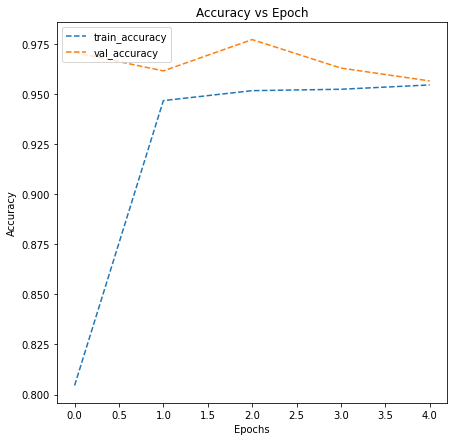

In [31]:
plot_accuracy(history1)




Now I will build a model using BatchNormalization and using LeakyRelu as the activation function to see if the results improve.

###<b> Model 2 with Batch Normalization

In [32]:
#Clearing backend
from tensorflow.keras import backend
backend.clear_session()

#Fixing the seed for random number generators
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

####<b> Building the Model

In [33]:
model2 = Sequential()
model2.add(Conv2D(32, (3,3), input_shape=(64, 64, 3), padding='same'))
model2.add(LeakyReLU(alpha=0.1))
model2.add(MaxPooling2D(pool_size=2))
model2.add(Dropout(0.2))
model2.add(Conv2D(filters=32,kernel_size=2,padding="same"))
model2.add(LeakyReLU(alpha=0.1))
model2.add(MaxPooling2D(pool_size=2))
model2.add(BatchNormalization())
model2.add(Dropout(0.2))
model2.add(Conv2D(filters=32,kernel_size=2,padding="same"))
model2.add(LeakyReLU(alpha=0.1))
model2.add(MaxPooling2D(pool_size=2))
model2.add(BatchNormalization())
model2.add(Dropout(0.2))
model2.add(Conv2D(filters=32,kernel_size=2,padding="same"))
model2.add(LeakyReLU(alpha=0.1)) 
model2.add(MaxPooling2D(pool_size=2))
model2.add(Dropout(0.2))


model2.add(Flatten())

model2.add(Dense(512))
model2.add(Dropout(0.4))



model2.add(Dense(2, activation='softmax'))

adam = optimizers.Adam(learning_rate=0.001)

model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4128      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 32)        0         
                                                        

####<b>Compiling the model

In [34]:
model2.compile(loss="binary_crossentropy", optimizer=adam, metrics = ['accuracy'])

<b> Using callbacks

In [35]:
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]

<b>Fit and train the model

In [ ]:
history2 = model2.fit(train_images,train_labels,batch_size=32,callbacks=callbacks,validation_split=0.2,epochs=20,verbose=1)

Epoch 1/20
624/624 [==============================] - 10s 13ms/step - loss: 0.5083 - accuracy: 0.7724 - val_loss: 0.2242 - val_accuracy: 0.9653
Epoch 2/20
624/624 [==============================] - 8s 13ms/step - loss: 0.2107 - accuracy: 0.9333 - val_loss: 0.1864 - val_accuracy: 0.9786
Epoch 3/20
624/624 [==============================] - 8s 13ms/step - loss: 0.1865 - accuracy: 0.9397 - val_loss: 0.1496 - val_accuracy: 0.9840
Epoch 4/20
624/624 [==============================] - 8s 13ms/step - loss: 0.1764 - accuracy: 0.9435 - val_loss: 0.1580 - val_accuracy: 0.9796
Epoch 5/20
624/624 [==============================] - 8s 13ms/step - loss: 0.1684 - accuracy: 0.9445 - val_loss: 0.1168 - val_accuracy: 0.9796
Epoch 6/20
624/624 [==============================] - 8s 13ms/step - loss: 0.1655 - accuracy: 0.9455 - val_loss: 0.2094 - val_accuracy: 0.9665
Epoch 7/20
624/624 [==============================] - 8s 13ms/step - loss: 0.1607 - accuracy: 0.9470 - val_loss: 0.2099 - val_accuracy: 0.970

<b>Plotting the train and validation accuracy

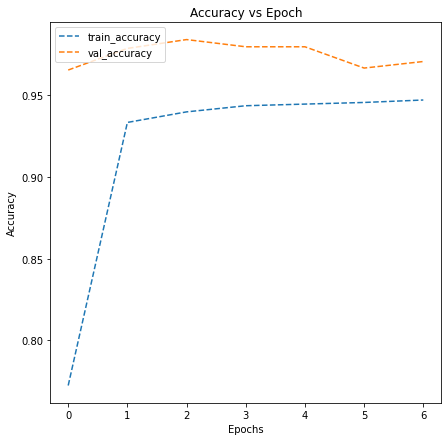

In [ ]:
# plotting the accuracies
plot_accuracy(history2)

####<b>Evaluating the model

In [ ]:
# Evaluate the model to calculate the accuracy
accuracy2 = model2.evaluate(test_images, test_labels, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy2[1])

82/82 [==============================] - 1s 7ms/step - loss: 0.1666 - accuracy: 0.9481

 Test_Accuracy:- 0.9480769038200378



I attempted several different layers of batch normalization and saw strong performance however there was no significant improvement over the previous model. It is worth mentioning though that there were 5 fewer misclassifications of uninfected on cases that were actually infected, which is what I am aiming to minimize. 

<b> Generating the classification report and confusion matrix 

              precision    recall  f1-score   support

           0       0.93      0.96      0.95      1300
           1       0.96      0.93      0.95      1300

    accuracy                           0.95      2600
   macro avg       0.95      0.95      0.95      2600
weighted avg       0.95      0.95      0.95      2600



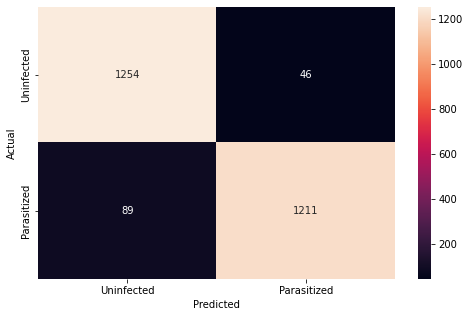

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred2 = model2.predict(test_images)
pred2 = np.argmax(pred2,axis = 1) 
y_true = np.argmax(test_labels,axis = 1)
#Printing the classification report
print(classification_report(y_true,pred2))

#Plotting the heatmap using confusion matrix
cm2 = confusion_matrix(y_true,pred2)
plt.figure(figsize=(8,5))
sns.heatmap(cm2, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Now I will try Data Augmentation to see if we can get better results. 




###<b>Model 3 with Data Augmentation

In [36]:
#Clearing backend
from tensorflow.keras import backend
backend.clear_session()
#Fixing the seed for random number generators
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

####<b> Using image data generator

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, train_size=0.2, random_state=42)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Using ImageDataGenerator to generate images

train_datagen = ImageDataGenerator(horizontal_flip=True, 
                                  zoom_range = 0.5, rotation_range=30)
val_datagen  = ImageDataGenerator()

# Flowing training images using train_datagen generator
train_generator = train_datagen.flow(x = X_train, y = y_train, batch_size=64, seed=42, shuffle=True)     

# Flowing validation images using val_datagen generator
val_generator =  val_datagen.flow(x= X_val, y = y_val, batch_size=64, seed=42, shuffle=True)

####<B>Visualizing Augmented images

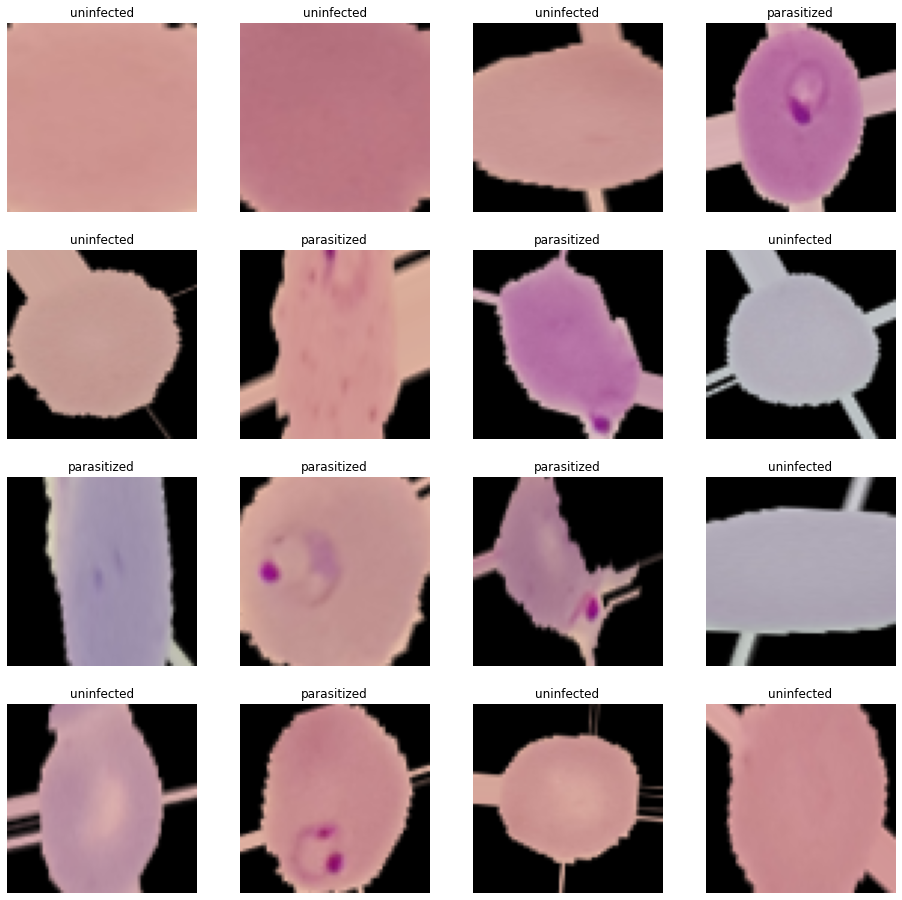

In [38]:
#Creating an iterable for images and labels from the training data
images, labels = next(train_generator)

#Plotting 16 images from the training data
fig, axes = plt.subplots(4, 4, figsize = (16, 8))
fig.set_size_inches(16, 16)
for (image, label, ax) in zip(images, labels, axes.flatten()):
    ax.imshow(image)
    if label[1] == 1: 
        ax.set_title('parasitized')
    else:
        ax.set_title('uninfected')
    ax.axis('off')

#####<b>Observations and insights:

* The augmented images provide several transformations including zoom, rotation, and flip. The goal here is to see if these transformations lead to a stronger model that can better generalize and learn more thoroughly how to spot infected cells. 

####<b>Building the Model

In [39]:
model3 = Sequential()

model3.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu",input_shape=(64,64,3)))
model3.add(MaxPooling2D(pool_size=2))
model3.add(Dropout(0.2))
model3.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model3.add(MaxPooling2D(pool_size=2))
model3.add(Dropout(0.2))
model3.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model3.add(MaxPooling2D(pool_size=2))
model3.add(Dropout(0.2))
model3.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu")) 
model3.add(MaxPooling2D(pool_size=2))
model3.add(Dropout(0.2))

model3.add(Flatten())

model3.add(Dense(512,activation="relu"))
model3.add(Dropout(0.4))
model3.add(Dense(2,activation="softmax")) 
adam = optimizers.Adam(learning_rate=0.001)

model3.compile(loss='binary_crossentropy', optimizer=adam, metrics = ['accuracy'])
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 32)        0

<b>Using Callbacks

In [40]:
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]

<b> Fit and Train the model

In [41]:
history3 = model3.fit(train_generator, 
                                  validation_data=val_generator,
                                  batch_size=32,callbacks=callbacks,
                                  epochs=20,verbose=1)

Epoch 1/20
78/78 [==============================] - 12s 132ms/step - loss: 0.6863 - accuracy: 0.5534 - val_loss: 0.6726 - val_accuracy: 0.5898
Epoch 2/20
78/78 [==============================] - 10s 128ms/step - loss: 0.6621 - accuracy: 0.6033 - val_loss: 0.6374 - val_accuracy: 0.6204
Epoch 3/20
78/78 [==============================] - 10s 127ms/step - loss: 0.6205 - accuracy: 0.6696 - val_loss: 0.5245 - val_accuracy: 0.8286
Epoch 4/20
78/78 [==============================] - 10s 126ms/step - loss: 0.4071 - accuracy: 0.8401 - val_loss: 0.2437 - val_accuracy: 0.9334
Epoch 5/20
78/78 [==============================] - 10s 127ms/step - loss: 0.2963 - accuracy: 0.8914 - val_loss: 0.1933 - val_accuracy: 0.9421
Epoch 6/20
78/78 [==============================] - 10s 126ms/step - loss: 0.2837 - accuracy: 0.8930 - val_loss: 0.2101 - val_accuracy: 0.9382
Epoch 7/20
78/78 [==============================] - 10s 126ms/step - loss: 0.2766 - accuracy: 0.9036 - val_loss: 0.1907 - val_accuracy: 0.9473

####<B>Evaluating the model

<b>Plotting the train and validation accuracy

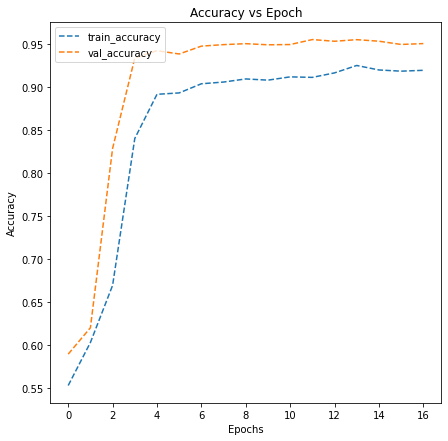

In [42]:
# plotting the accuracies
plot_accuracy(history3)

In [43]:
# Evaluating the model on test data
accuracy3 = model3.evaluate(test_images, test_labels, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy3[1])

82/82 [==============================] - 1s 7ms/step - loss: 0.1671 - accuracy: 0.9442

 Test_Accuracy:- 0.9442307949066162


<B>Plotting the classification report and confusion matrix

              precision    recall  f1-score   support

           0       0.93      0.96      0.95      1300
           1       0.96      0.92      0.94      1300

    accuracy                           0.94      2600
   macro avg       0.94      0.94      0.94      2600
weighted avg       0.94      0.94      0.94      2600



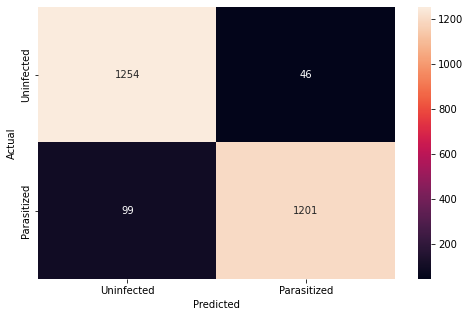

In [44]:
pred3 = model3.predict(test_images)
pred3 = np.argmax(pred3,axis = 1) 
y_true = np.argmax(test_labels,axis = 1)

#Printing the classification report
print(classification_report(y_true,pred3))

#Plotting the heatmap using confusion matrix
cm3 = confusion_matrix(y_true,pred3)
plt.figure(figsize=(8,5))
sns.heatmap(cm3, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

<b> Now let us try to use a pretrained model like VGG16 and check how it performs on our data.

### **Pre-trained model (VGG16)**

In [ ]:
#Clearing backend
from tensorflow.keras import backend
backend.clear_session()
#Fixing the seed for random number generators
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import Model

vgg = VGG16(include_top=False, weights='imagenet', input_shape=(64,64,3))
vgg.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
______________________________________________________________

In [ ]:
transfer_layer = vgg.get_layer('block5_pool')
vgg.trainable=False

 
 
x = Flatten()(transfer_layer.output) 
x = Dense(256, activation='relu')(x)


x = Dropout(0.3)(x)



x = BatchNormalization()(x)
pred = Dense(2, activation='softmax')(x)

model4 = Model(vgg.input, pred) #Initializing the model

####<b>Compiling the model

In [ ]:
model4.compile(loss='binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

<b> using callbacks

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]

<b>Fitting and training the model

In [ ]:
#Fitting the model and running the model for 10 epochs
history4 = model4.fit(
            train_images, train_labels,
            epochs=10,
            callbacks=callbacks,
            batch_size=32,
            validation_split=0.2,
            verbose=1
)

Epoch 1/10
624/624 [==============================] - 28s 41ms/step - loss: 0.2538 - accuracy: 0.8995 - val_loss: 0.1490 - val_accuracy: 0.9545
Epoch 2/10
624/624 [==============================] - 24s 39ms/step - loss: 0.2108 - accuracy: 0.9186 - val_loss: 0.2886 - val_accuracy: 0.8862
Epoch 3/10
624/624 [==============================] - 24s 39ms/step - loss: 0.2012 - accuracy: 0.9220 - val_loss: 0.1217 - val_accuracy: 0.9635
Epoch 4/10
624/624 [==============================] - 24s 39ms/step - loss: 0.1994 - accuracy: 0.9233 - val_loss: 0.1950 - val_accuracy: 0.9239
Epoch 5/10
624/624 [==============================] - 26s 41ms/step - loss: 0.1878 - accuracy: 0.9282 - val_loss: 0.1898 - val_accuracy: 0.9405


<b>Plotting the train and validation accuracy

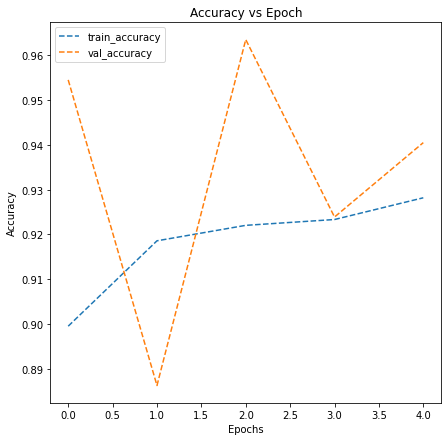

In [ ]:
# plotting the accuracies
plot_accuracy(history4)

#####**Observations:**

* The pre-trained model performed worse than our previous models 

* The strong difference in the validation and train curves could signify underfitting, meaning that the model isn't complex enough to strongly perform on the training data. 

####<b> Evaluating the model

In [ ]:
accuracy4 = model4.evaluate(test_images, test_labels, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy4[1])


82/82 [==============================] - 3s 38ms/step - loss: 0.1800 - accuracy: 0.9342

 Test_Accuracy:- 0.9342307448387146


<b>Plotting the classification report and confusion matrix

              precision    recall  f1-score   support

           0       0.93      0.94      0.93      1300
           1       0.94      0.93      0.93      1300

    accuracy                           0.93      2600
   macro avg       0.93      0.93      0.93      2600
weighted avg       0.93      0.93      0.93      2600



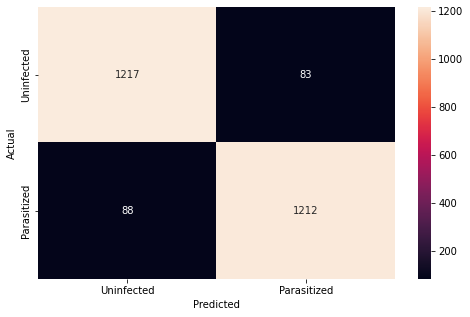

In [ ]:
pred4 = model4.predict(test_images)
pred4 = np.argmax(pred4,axis = 1) 
y_true = np.argmax(test_labels,axis = 1)

#Printing the classification report
print(classification_report(y_true,pred4))

#Plotting the heatmap using confusion matrix
cm4 = confusion_matrix(y_true,pred4)
plt.figure(figsize=(8,5))
sns.heatmap(cm4, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## **The best model is model1, and I will improve it by tuning it using Keras Tuner**

In [ ]:
#Clearing backend
from tensorflow.keras import backend
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout  
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from random import shuffle

backend.clear_session()

np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [ ]:
pip install keras-tuner --upgrade

     |████████████████████████████████| 98 kB 3.3 MB/s 


In [ ]:
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
import time


In [ ]:
def build_model5(hp):

  model5=Sequential()
  model5.add(Conv2D(hp.Int('input_units',min_value = 32, max_value = 256, step = 32),kernel_size=2,padding="same",activation="relu",input_shape=(64,64,3)))
  model5.add(MaxPooling2D(pool_size=2))
  model5.add(Dropout(0.2))
  
  model5.add(Conv2D(hp.Int('input_units2',min_value = 32, max_value = 256, step = 32),kernel_size=2,padding="same",activation="relu"))
  model5.add(MaxPooling2D(pool_size=2))
  model5.add(Dropout(0.2))
  
  model5.add(Conv2D(hp.Int('input_units3',min_value = 32, max_value = 256, step = 32),kernel_size=2,padding="same",activation="relu"))
  model5.add(MaxPooling2D(pool_size=2))
  model5.add(Dropout(0.2))
  
  model5.add(Conv2D(hp.Int('input_units4',min_value = 32, max_value = 256, step = 32),kernel_size=2,padding="same",activation="relu")) #adding a 4th layer
  model5.add(MaxPooling2D(pool_size=2))
  model5.add(Dropout(0.2))


  model5.add(Flatten())

  model5.add(Dense(hp.Choice('Dense layer', [64,128,256,512,1024]),activation="relu"))
  model5.add(Dropout(0.4))
  model5.add(Dense(2,activation="softmax"))#2 represent output layer neurons
  model5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
  
  return model5

In [ ]:
tuner = RandomSearch(
    build_model5,
    objective="val_accuracy",
    max_trials=5,
     directory="sample_dir15",
    project_name="proj15",
)

In [ ]:
tuner.search(x = train_images, 
             y = train_labels,
             epochs = 3,
             batch_size = 64,
             validation_data = (test_images,test_labels))
             
          

Trial 5 Complete [00h 00m 56s]
val_accuracy: 0.9515384435653687

Best val_accuracy So Far: 0.9557692408561707
Total elapsed time: 00h 10m 45s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

Results summary
Results in sample_dir15/proj15
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
input_units: 224
input_units2: 64
input_units3: 160
input_units4: 64
Dense layer: 64
Score: 0.9557692408561707
Trial summary
Hyperparameters:
input_units: 160
input_units2: 160
input_units3: 128
input_units4: 224
Dense layer: 512
Score: 0.954230785369873
Trial summary
Hyperparameters:
input_units: 224
input_units2: 192
input_units3: 96
input_units4: 192
Dense layer: 256
Score: 0.9538461565971375
Trial summary
Hyperparameters:
input_units: 224
input_units2: 160
input_units3: 64
input_units4: 128
Dense layer: 1024
Score: 0.9538461565971375
Trial summary
Hyperparameters:
input_units: 64
input_units2: 192
input_units3: 32
input_units4: 224
Dense layer: 256
Score: 0.9515384435653687


## Now that the tuner gave the best hyperparameters for our model, I can rebuild the model using these parameters. 

In [ ]:
model6=Sequential()
model6.add(Conv2D(filters=160,kernel_size=2,padding="same",activation="relu",input_shape=(64,64,3))) #altered the shape to allow grayscale images to be fed in, refer to grayscale section
model6.add(MaxPooling2D(pool_size=2))
model6.add(Dropout(0.2))
model6.add(Conv2D(filters=160,kernel_size=2,padding="same",activation="relu"))
model6.add(MaxPooling2D(pool_size=2))
model6.add(Dropout(0.2))
model6.add(Conv2D(filters=128,kernel_size=2,padding="same",activation="relu"))
model6.add(MaxPooling2D(pool_size=2))
model6.add(Dropout(0.2))
model6.add(Conv2D(filters=224,kernel_size=2,padding="same",activation="relu")) 
model6.add(Dropout(0.2))


model6.add(Flatten())

model6.add(Dense(512,activation="relu"))
model6.add(Dropout(0.4))
model6.add(Dense(2,activation="softmax"))#2 represent output layer neurons 
model6.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 64, 64, 160)       2080      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 160)       0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 32, 32, 160)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 160)       102560    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 160)       0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 16, 16, 160)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 128)      

####<b> Compiling the model

In [ ]:
model6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

<b> Using Callbacks

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]

<b>Fit and Train the model

In [ ]:
history6=model6.fit(train_images,train_labels,batch_size=32,callbacks=callbacks,  validation_split=0.2,epochs=20,verbose=1)

Epoch 1/20
624/624 [==============================] - 34s 52ms/step - loss: 0.5070 - accuracy: 0.7300 - val_loss: 0.1904 - val_accuracy: 0.9439
Epoch 2/20
624/624 [==============================] - 31s 50ms/step - loss: 0.1631 - accuracy: 0.9485 - val_loss: 0.1748 - val_accuracy: 0.9665
Epoch 3/20
624/624 [==============================] - 32s 51ms/step - loss: 0.1480 - accuracy: 0.9545 - val_loss: 0.1026 - val_accuracy: 0.9700
Epoch 4/20
624/624 [==============================] - 32s 51ms/step - loss: 0.1393 - accuracy: 0.9551 - val_loss: 0.1222 - val_accuracy: 0.9718
Epoch 5/20
624/624 [==============================] - 32s 51ms/step - loss: 0.1332 - accuracy: 0.9562 - val_loss: 0.1691 - val_accuracy: 0.9565


####<b> Evaluating the model

In [ ]:
accuracy6 = model6.evaluate(test_images, test_labels, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy6[1])

82/82 [==============================] - 2s 19ms/step - loss: 0.1587 - accuracy: 0.9485

 Test_Accuracy:- 0.9484615325927734


<b> Plotting the confusion matrix

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1300
           1       0.95      0.95      0.95      1300

    accuracy                           0.95      2600
   macro avg       0.95      0.95      0.95      2600
weighted avg       0.95      0.95      0.95      2600



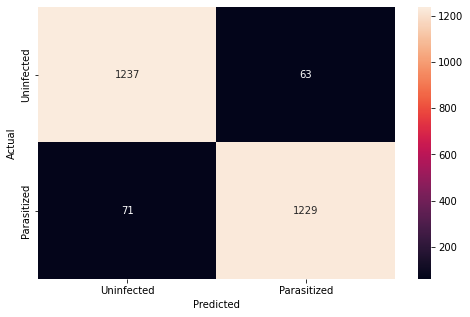

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred6 = model6.predict(test_images)
pred6 = np.argmax(pred6,axis = 1) 
y_true = np.argmax(test_labels,axis = 1)

#Printing the classification report
print(classification_report(y_true,pred6))

#Plotting the heatmap using confusion matrix
cm6 = confusion_matrix(y_true,pred6)
plt.figure(figsize=(8,5))
sns.heatmap(cm6, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

<b> Plotting the Train and validation curves

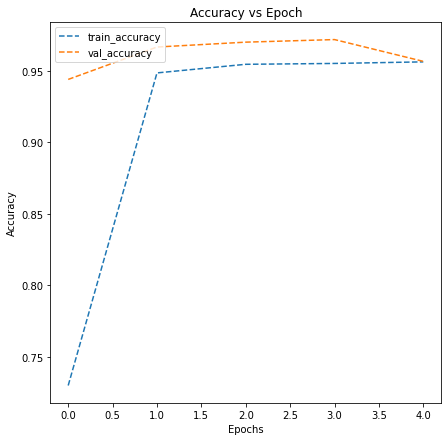

In [ ]:
plot_accuracy(history6)

# Now I'll use this model with different pre-processing methods for our images to see if I can get better results

In [ ]:
 import matplotlib.cm as cm

Grayscale

In [ ]:
import cv2
gray_train=[]   # to hold the gray image array
for i in np.arange(0,24958,1):
  a=cv2.cvtColor(train_images[i],cv2.COLOR_BGR2GRAY)
  gray_train.append(a)
gray_train=np.array(gray_train)

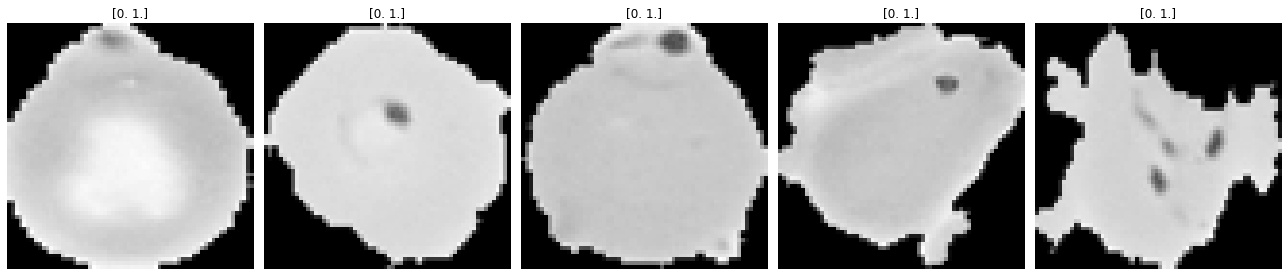

In [ ]:
viewimage=np.random.randint(1,100,5)
fig,ax=plt.subplots(1,5,figsize=(18,18))
for t,i in zip(range(5),viewimage):
  Title=train_labels[i]
  ax[t].set_title(Title)
  ax[t].imshow(gray_train[i], cmap = cm.gray)
  ax[t].set_axis_off()
  fig.tight_layout()

In [ ]:
import cv2
gray_test=[]   # to hold the gray image array
for i in np.arange(0,2600,1):
  a=cv2.cvtColor(test_images[i],cv2.COLOR_BGR2GRAY)
  gray_test.append(a)
gray_test=np.array(gray_test)

In [ ]:
new_gray_train = gray_train.reshape(len(gray_train),64,64,1)
new_gray_test = gray_test.reshape(len(gray_test),64,64,1)

Altering the final model to allow the (64,64,1) shape, and then I will fit the model onto the new altered images.

In [ ]:
model7=Sequential()
model7.add(Conv2D(filters=160,kernel_size=2,padding="same",activation="relu",input_shape=(64,64,1))) #altered the shape to allow grayscale images to be fed in, refer to grayscale section
model7.add(MaxPooling2D(pool_size=2))
model7.add(Dropout(0.2))
model7.add(Conv2D(filters=160,kernel_size=2,padding="same",activation="relu"))
model7.add(MaxPooling2D(pool_size=2))
model7.add(Dropout(0.2))
model7.add(Conv2D(filters=128,kernel_size=2,padding="same",activation="relu"))
model7.add(MaxPooling2D(pool_size=2))
model7.add(Dropout(0.2))
model7.add(Conv2D(filters=224,kernel_size=2,padding="same",activation="relu")) 
model7.add(Dropout(0.2))


model7.add(Flatten())

model7.add(Dense(512,activation="relu"))
model7.add(Dropout(0.4))
model7.add(Dense(2,activation="softmax"))#2 represent output layer neurons 
model7.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 64, 64, 160)       800       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 160)       0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 32, 32, 160)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 160)       102560    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 160)       0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 16, 16, 160)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 128)      

In [ ]:
model7.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history7=model7.fit(new_gray_train,train_labels,batch_size=32,callbacks=callbacks,validation_split=0.2,epochs=20,verbose=1)

Epoch 1/20
624/624 [==============================] - 34s 53ms/step - loss: 0.6566 - accuracy: 0.6303 - val_loss: 0.7135 - val_accuracy: 0.5992
Epoch 2/20
624/624 [==============================] - 33s 53ms/step - loss: 0.2717 - accuracy: 0.8890 - val_loss: 0.2466 - val_accuracy: 0.9409
Epoch 3/20
624/624 [==============================] - 33s 53ms/step - loss: 0.1615 - accuracy: 0.9457 - val_loss: 0.1164 - val_accuracy: 0.9659
Epoch 4/20
624/624 [==============================] - 33s 53ms/step - loss: 0.1520 - accuracy: 0.9479 - val_loss: 0.1126 - val_accuracy: 0.9704
Epoch 5/20
624/624 [==============================] - 33s 53ms/step - loss: 0.1489 - accuracy: 0.9484 - val_loss: 0.2451 - val_accuracy: 0.9377
Epoch 6/20
624/624 [==============================] - 33s 53ms/step - loss: 0.1466 - accuracy: 0.9495 - val_loss: 0.1867 - val_accuracy: 0.9543


In [ ]:
accuracy7 = model7.evaluate(new_gray_test, test_labels, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy7[1])

82/82 [==============================] - 2s 19ms/step - loss: 0.1654 - accuracy: 0.9481

 Test_Accuracy:- 0.9480769038200378


              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1300
           1       0.95      0.95      0.95      1300

    accuracy                           0.95      2600
   macro avg       0.95      0.95      0.95      2600
weighted avg       0.95      0.95      0.95      2600



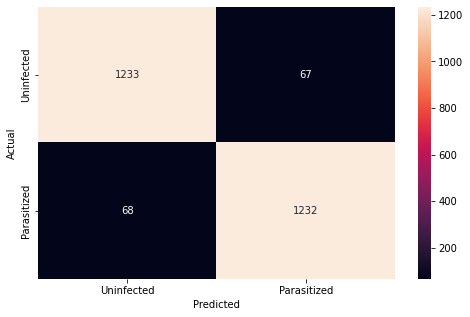

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred7 = model7.predict(new_gray_test)
pred7 = np.argmax(pred7,axis = 1) 
y_true = np.argmax(test_labels,axis = 1)

#Printing the classification report
print(classification_report(y_true,pred7))

#Plotting the heatmap using confusion matrix
cm7 = confusion_matrix(y_true,pred7)
plt.figure(figsize=(8,5))
sns.heatmap(cm7, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

###<b> Observations and Conclusions drawn from the grayscale model: 

The results improved because there is a better recall score for our second class. This means that there are fewer errors on instances that that are predicted to be uninfected who actually are infected. 

I will now try with HSV

In [ ]:
import cv2
gfx_3=[]   # to hold the HSV image array
for i in np.arange(0,24958,1):
  a=cv2.cvtColor(train_images[i],cv2.COLOR_BGR2HSV)
  gfx_3.append(a)
gfx_3=np.array(gfx_3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


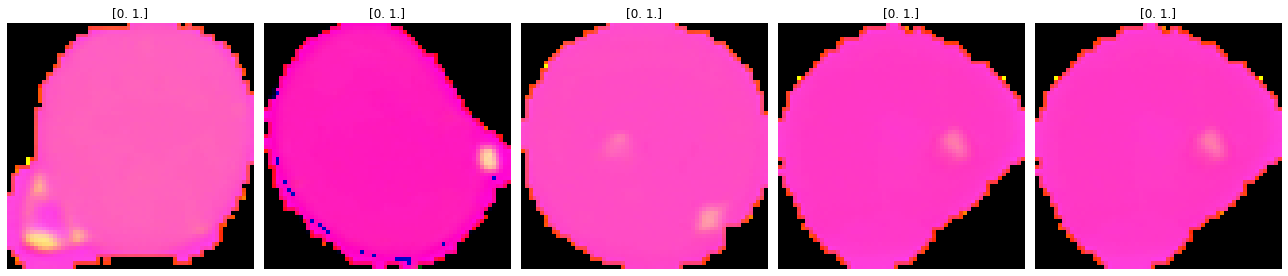

In [ ]:
viewimage=np.random.randint(1,100,5)
fig,ax=plt.subplots(1,5,figsize=(18,18))
for t,i in zip(range(5),viewimage):
  Title=train_labels[i]
  ax[t].set_title(Title)
  ax[t].imshow(gfx_3[i])
  ax[t].set_axis_off()
  fig.tight_layout()

In [ ]:
import cv2
gfx_4=[]   # to hold the HSV image array
for i in np.arange(0,2600,1):
  a=cv2.cvtColor(test_images[i],cv2.COLOR_BGR2HSV)
  gfx_4.append(a)
gfx_4=np.array(gfx_4)

In [ ]:
gfx_3[0].shape

(64, 64, 3)

Feeding the HSV images to the model: 

In [ ]:
model8=Sequential()
model8.add(Conv2D(filters=160,kernel_size=2,padding="same",activation="relu",input_shape=(64,64,3)))
model8.add(MaxPooling2D(pool_size=2))
model8.add(Dropout(0.2))
model8.add(Conv2D(filters=160,kernel_size=2,padding="same",activation="relu"))
model8.add(MaxPooling2D(pool_size=2))
model8.add(Dropout(0.2))
model8.add(Conv2D(filters=128,kernel_size=2,padding="same",activation="relu"))
model8.add(MaxPooling2D(pool_size=2))
model8.add(Dropout(0.2))
model8.add(Conv2D(filters=224,kernel_size=2,padding="same",activation="relu")) #adding a 4th layer
model8.add(MaxPooling2D(pool_size=2))
model8.add(Dropout(0.2))


model8.add(Flatten())

model8.add(Dense(512,activation="relu"))
model8.add(Dropout(0.4))
model8.add(Dense(2,activation="softmax"))#2 represent output layer neurons 
model8.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 64, 64, 160)       2080      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 32, 32, 160)       0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 32, 32, 160)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 160)       102560    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 16, 16, 160)       0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 16, 16, 160)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 16, 16, 128)      

####<b> Compiling the model

In [ ]:
model8.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

<b> Using Callbacks

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]

<b>Fitting and training the model

In [ ]:
history8=model8.fit(gfx_3,train_labels,batch_size=32,callbacks=callbacks,  validation_split=0.2,epochs=20,verbose=1)

Epoch 1/20
624/624 [==============================] - 31s 48ms/step - loss: 0.9998 - accuracy: 0.6216 - val_loss: 0.8050 - val_accuracy: 0.1194
Epoch 2/20
624/624 [==============================] - 30s 48ms/step - loss: 0.6492 - accuracy: 0.6385 - val_loss: 0.9404 - val_accuracy: 0.1440
Epoch 3/20
624/624 [==============================] - 30s 48ms/step - loss: 0.6398 - accuracy: 0.6508 - val_loss: 0.8094 - val_accuracy: 0.1520


####<b> Evaluating the model

In [ ]:
accuracy8 = model8.evaluate(gfx_4, test_labels, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy7[1])

82/82 [==============================] - 2s 18ms/step - loss: 0.6685 - accuracy: 0.5612

 Test_Accuracy:- 0.9480769038200378


<b> Plotting the confusion matrix

              precision    recall  f1-score   support

           0       0.82      0.16      0.26      1300
           1       0.53      0.96      0.69      1300

    accuracy                           0.56      2600
   macro avg       0.68      0.56      0.48      2600
weighted avg       0.68      0.56      0.48      2600



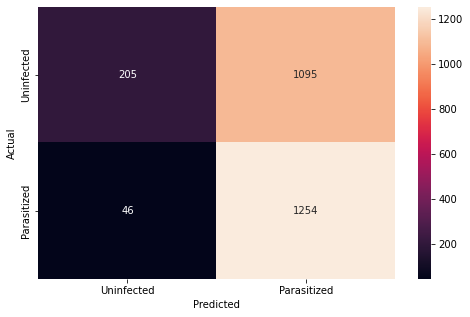

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred8 = model8.predict(gfx_4)
pred8 = np.argmax(pred8,axis = 1) 
y_true = np.argmax(test_labels,axis = 1)

#Printing the classification report
print(classification_report(y_true,pred8))

#Plotting the heatmap using confusion matrix
cm8 = confusion_matrix(y_true,pred8)
plt.figure(figsize=(8,5))
sns.heatmap(cm8, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

<b> Plotting the Train and validation curves

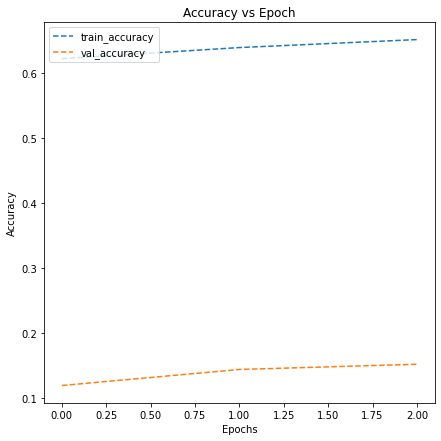

In [ ]:
plot_accuracy(history8)

###<b> Observations and Conclusions drawn from the HSV model: 

* The results are significantly worsened after converting our images to HSV, so I will be sticking with grayscale

###<b> Observations and Conclusions drawn from the final model: 

* The final model contains the hyperparameters, layers, and image modifications that provided the best recall performance which is what I was looking for. 

* This is because it had the lowest number of cases where it misclassified an infected cell as uninfected, which is the measure that I am trying to minimize. 

* The reason I want to minimize this number is because misclassifying an uninfected cell as infected isn't a strong worry because there is no harm, however misclassifying an infected cell as infected is dangerous because the cell would get more and more infected and can lead to a state beyond treatment. 



**Improvements that can be done:**<br>


*  In this study, I used one pre-trained model which did not improve the performance. However, I can try using other pre-trained models such as ResNet and see it how it performs on the data. 

*  Despite not seeing improvement with augmented images or HSV conversion, I did see a positive effect from grayscaling the images. This could mean that other possible transformations can potentially further increase the performance. I can use the opencv library to see other transformations available or try other methods of image augmentation. 